In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Bayesian linear regression

We have seen [previously](regression_regularisation.ipynb) how i) regularisation can be intrepreted in terms of a probabilistic prior over the regression weights, and ii) how MAP estimation of the weights mitigates some of the effects of overfitting. However, the approaches we have considered so far have not returned uncertainty estimates in the weights. Uncertainty estimates are key when, for example, making decisions and performing online incremental updates to the model. 

In this section we will consider Bayesian approaches to regression that return uncertainty in parameter estimates. The probabilisitc approach involves two phases. First we explicitly define our assumptions about how the data and parameters are generated. This is called the probabilistic model. Second, we use the rules of probability to manipulate the probabilistic model to perform the inferences we wish to make. Let's walk through these two steps in detail.


### 1. Probabilistic model

First we describe the probabilisitc model. You can think of this as a probabilistic recipe (or probabilistic program) for sampling datasets together with their underlying parameters. This recipe should encode knowledge about what we believe a typical dataset might look like before observing data. 

In the current case the probabilistic programme samples the regression weights from a Gaussian, forms the regression function, samples $N$ input locations and then samples $N$ outputs. (We have assumed the observation noise $\sigma_y^2$ and prior variance on the weights $\sigma_{\mathbf{w}}^2$ are known).

1. sample the weights $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$ for $m=1...M$ 

2. define the regression function $f_{\mathbf{w}}^{(m)}(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}^{(m)}$

3. sample $N$ input locations $\mathbf{x}^{(m)}_n \sim p(\mathbf{x})$ for $n=1...N$

4. sample $N$ output locations $y_n |\mathbf{w}^{(m)},\mathbf{x}^{(m)}_n,\sigma_{y}^2  \sim \mathcal{N}(f^{(m)}_{\mathbf{w}}(\mathbf{x}^{(m)}_n),\sigma_{y}^2)$ for $n=1...N$

Here are four datasets produced from this probabilistic model using linear basis functions and scalar inputs:

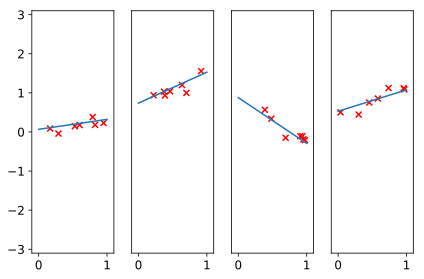

In [2]:
D = 1 # order of polynomial
M = 4 # number of samples of model
N = 7 # number of data points per model

var_w = 1 # a priori variance of weights
var_y = 0.01 # observation noise variance

# input locations
xs = np.linspace(0, 1, 100) # 100 points equispaced between 0 and 1

# polynomial basis functions
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) 


# Gaussian basis functions
# var_phi = 0.05;
# phi_pred = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in xs]) 
# phi_samp = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in x_samp])

for m in range(1, M+1):
    
    # input locations
    x_samp = np.random.uniform(0, 1, N) 

    # polynomial basis functions
    phi_samp = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp]) 


    
    # sample weights
    w = np.random.normal(0, np.power(var_w, 0.5), D+1)

    # plot function at input locations
    fs = phi_pred.dot(w) # output of the model at the points above
    
    y_samp = phi_samp.dot(w) + np.random.normal(0, np.power(var_y, 0.5), N)
    
    plt.subplot(1,M,m)
    plt.plot(xs, fs) # plot predictions
    plt.scatter(x_samp, y_samp, marker = 'x', color = 'red') # plot predictions
   
    plt.xlim([-0.1, 1.1])
    plt.ylim([-3.1, 3.1])
    if m  is not 1:
        remove_axes('y')
    
plt.tight_layout()
plt.show()

toggle_code()

The probabilistic model is a joint distribution over all of the random variables: 
\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2)
\end{align}

All aspects of this model can be critiqued:

The assumption of **independent Gaussian observation noise** can be appropriate, e.g. if there are many independent noise sources and the central limit theorem has kicked in, and it leads to analytic inference. However, it may be inappropriate if the output noise is correlated or if there are outliers in the data (e.g. see [question 1B](regression_linear.ipynb) and [question 2](regression_regularisation.ipynb)).

The **zero mean Gaussian prior over the weights** encodes the fact that _a priori_ we expect the weight values to take values within a few standard deviations $\sigma_{\mathbf{w}}$ of zero. We will see in a moment that the use of a Gaussian distribution leads to tractable inference schemes. However, other distributions might be appropriate depending on the circumstances. For example, you might have reason to suspect that only a small number of the features $\phi_d(\mathbf{x})$ affect the output, in which case distributions that put more probability mass at zero and in the tails than a Gaussian might be more appropriate. Such distributions are called sparse distribtions and examples include the [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) and [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution). 

Notice here that our probabilistic model includes a **distribution over the input locations** are sampled. This is required to sample datasets, but it is not something that we encountered when we [interpreted regularisation in terms of MAP inference in a probabilistic model](regression_regularisation.ipynb). We will see that the distribution over the inputs does not affect the inference for the weights. This is why we have not specified a distributional family for $p(x)$.

### 2.1 Probabilistic inference for the weights

Now let's perform probabilistic inference for the weights. This involves computing the probability of the weights given the observed inputs and outputs $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$, or for shorthand the posterior distribution of the weights. 

Applying the product rule to the probabilistic model we find that the posterior can be computed by multiplying the prior $p(\mathbf{w}| \sigma_{\mathbf{w}}^2)$ (what we knew about the parameters before seeing data) with the likelihood of the parameters $p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)$ (what the data tell us about the parameters), and renormalising to ensure the density integrates to 1:

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)  \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)
\end{align}

<details>
<summary>Detailed derivation for the posterior over the weights</summary>
    
    
Starting from the posterior distribution, $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$. we first apply the product rule,

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = 
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 }
 p(\mathbf{w},\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2).
\end{align}

Now substituing in the joint distribution specified by the probabilistic model yields

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) & =
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{X}) p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) 
  = 
  \frac{1}{
 p(\mathbf{y} | \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) \\ 
  & \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2).
\end{align}

In the last line we have dropped the term that does not depend on the weights: this is a normalising constant that we can recompute later by ensuring the distribution integrates to one. 
<div>

</div>
</details>

The next step is to substitute the distributional forms for the prior and the likelihood. The prior is a Gaussian distribution over the weights. The likelihood  also takes a Gaussian form when viewed as a _function of the weights_:


$$\begin{align}
p(\mathbf{w}| \sigma_{\mathbf{w}}^2) &= \frac{1}{(2\pi \sigma_{\mathbf{w}}^2)^{D/2}}\text{exp}\big(-\frac{1}{2\sigma_w^2}\mathbf{w}^\top \mathbf{w}\big)\\
p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) &= \frac{1}{(2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})\big)
\end{align}$$

Since the product of two Gaussians yield another Gaussian function the posterior will also be a Gaussian distribution,

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }).
\end{align}

where 

\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }  = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1} \;\;\; \text{and} \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } =  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}


<details>
<summary>Detailed derivation for the posterior mean and covariance</summary>
 
<div>
In order to find the posterior mean and covariance, we i) multiply together the prior and likelihood and expand the result in terms of an exponentiated quadratic in $\mathbf{w}$,  and then ii) compare coefficients to identify the posterior mean and covariance.
     
Step (i): Multiplying prior and likelihood 

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &\propto \text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) -\frac{1}{2 \sigma_{\mathbf{w}}^2}\mathbf{w}^\top  \mathbf{w}  \big)\\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)\mathbf{w} + \frac{1}{\sigma_y^2} \mathbf{w}^\top \boldsymbol{\Phi}^\top \mathbf{y} \right) 
\end{align}


Step (ii): comparing coefficients to a Gaussian


\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &= \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }), \\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }\mathbf{w} + \mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \right).
\end{align}

Hence the posterior covariance and mean are given by:

\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }  = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1}, \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } =  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}

</div>
</details>

In a moment we will derive the probabilistic approach to prediction. Before we do this, let's take some time to consider the results above.

First, notice that the mean of the posterior distribution over the weights can be expressed as

$$
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }  = (\sigma^{-2}\boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \lambda \mathbf{I})\boldsymbol{\Phi}^\top \mathbf{y}
$$

where $\lambda = \sigma^2_\mathbf{w} / \sigma^2_y $. This recovers the solution from regularised least squares fitting which we previously interpreted as finding the _maximum a posteriori_ setting of the weights given the data,

\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2).
\end{align}

This all adds up because the posterior is Gaussian and the most probable weight under a Gaussian is the mean value.

\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } = \mathbb{E}_{p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}(\mathbf{w}).
\end{align}

Second, notice that the **prior** distribution and the **posterior** distribution belong to the same family (i.e. Gaussian). When a model has this property, the prior and likelihood are said to be **conjugate**, or for short it is said to have a **conjugate prior**. Conjugate priors lead to tractable and convenient analytic posterior distributions. 

### 2.2 Probabilistic inference for prediction

Now let's consider how to use probabilistic inference to make predictions for an unseen output $y^*$ at input location $\mathbf{x}^*$. The MAP and maximum likelihood methods use a point estimate for the weights, $\hat{\mathbf{w}}$, simply computing $p(y^* | \mathbf{x}^*, \hat{\mathbf{w}},\sigma_y^2,\sigma_{\mathbf{w}}^2$. This is equivalent to assuning that the weights are known to take the value $\hat{\mathbf{w}}$. The full probabilistic approach considers undertainty in $\mathbf{w}$ and is therefore more complex. The full solution is a probability distribution over the unseen output, give the input and the training data, $p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$, which can be computed by
$$
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \int p(y^* | \mathbf{x}^*, \mathbf{w},\sigma_y^2) p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) d\mathbf{w}.
$$

So, the predictive is formed by considering every possible setting of the underlying weights, computing the associated prediction $p(y^* | \mathbf{x}^*, \mathbf{w})$,  weighting this by the posterior probability of the weight taking that value $p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$, and averaging these weighted predictions together. The form of the predictive distribution may seem intuitively obvious, but for a full derivation see below.

<details>
<summary>Detailed derivation for the predictive distribution</summary>
 
<div>
First we apply the sum rule to introduce the weight back into the expression. The sum rule states  $p(A|C) = \int p(A,B|C) \text{d}B$ and we use $A = y^* $, $B = \mathbf{w}$ and $C = \{x^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2\}$ so

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p(y^*,\mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Second we apply the product rule. The product rule states $p(A,B|C) = p(B|C)p(A|B,C)$ and we use the same variable associations as above to give

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Third, we use the structure of the probabilistic model to simplify the above expression (more precisely the conditional independencies implied by the model). By themselves, the test inputs $\mathbf{x}^*$ provide no information about the weights $\mathbf{w}$ so $p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p( \mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$. Moreover, if the weights $\mathbf{w}$ are known then the training data provide no additional useful information for prediction so $p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)$. 

Together these simplifications yield the expression for the predictive,

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w}.
\end{align}

</div>
</details>

There are long winded ways of performing the integral over the weights required to compute the predictive. Fortunately there is one simple route to the solution that involves no explicit integration at all. 

The posterior $p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$ is Gaussian. The test ouputs are a linear transformation of the weights plus Gaussian noise. Since Gaussians are closed under linear transforms and under the addition of Gaussian noise, the predictive distribution will also be Gaussian,

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \mathcal{N}(y^* ; \mu_{y^*|\mathbf{y},\mathbf{X}},\sigma^2_{y^*| \mathbf{y},\mathbf{X}}).
\end{align}

The expectation and variance of the predictive are then fairly simple to compute depending on the mean $\mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}$ and covariance $\Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}}$ of the posterior distribution over the weights and the basis functions at the test locations $\boldsymbol{\phi}_*$,

\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} = \boldsymbol{\phi}_{\ast}^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} = \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2.
\end{align}

<details>
<summary>Detailed derivation for the mean and variance of the predictive distribution</summary>
 
<div>
We know that the mean of the posterior predictive distribution is defined as $\mu_{y^*|\mathbf{y},\mathbf{X}} =  \mathbb{E}_{p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[y^*]$.     
 
We also know that we can write the posterior predictive distribution as

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w}.
\end{align}

So the mean of the poserior predictive can also be written

\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} =  \mathbb{E}_{p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[y^*] = \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ \mathbb{E}_{p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)}  [y^*] ]
\end{align}
    
The inner expectation is simple to compute $\mathbb{E}_{p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)}  [y^*] = \boldsymbol{\phi}_*^\top \mathbf{w}$ where we have used the fact that   $p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2) = \mathcal{N}(y^*; \boldsymbol{\phi}_*^\top \mathbf{w}, \sigma_y^2)$. 

Now we can compute the outer expectation

\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} =  \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ \boldsymbol{\phi}_*^\top \mathbf{w} ]= \boldsymbol{\phi}_*^\top\mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[\mathbf{w}] = \boldsymbol{\phi}_*^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
\end{align}

This result is essentially leveraging the [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation).


The variance of the predictive distribution $\sigma^2_{y^*| \mathbf{y},\mathbf{X}} =  \mathbb{E}_{p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[(y^* )^2]- \mu_{y^*|\mathbf{y},\mathbf{X}}^2$ can be computed in an identical way 

\begin{align}
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} & =  \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ \mathbb{E}_{p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)}  (y^*)^2] - \mu_{y^*|\mathbf{y},\mathbf{X}}^2 \\
& = \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ (\boldsymbol{\phi}_*^\top \mathbf{w})^2 +\sigma_y^2 ]  - \mu_{y^*|\mathbf{y},\mathbf{X}}^2\\ & = \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ (\boldsymbol{\phi}_*^\top \mathbf{w})^2 ] - \mu_{y^*|\mathbf{y},\mathbf{X}}^2 +\sigma_y^2 \\
& = \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[ (\boldsymbol{\phi}_*^\top \mathbf{w} - \mu_{y^*|\mathbf{y},\mathbf{X}})^2 ] +\sigma_y^2\\
& = \boldsymbol{\phi}_*^\top \mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}[(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})^\top] \boldsymbol{\phi}_*  + \sigma_y^2\\
& = \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2
\end{align}

There's a more simple lens through which to view these results. Consider the following result:

If $z_3 = A z_1 + z_2$ where $ z_1 \sim \mathcal{N}(\mu_1,\Sigma_1)$ and $z_2 \sim \mathcal{N}(0,\Sigma_2)$, then the marginal distribution induced over $z_3$ is $z_3 \sim \mathcal{N}(A \mu_1,A \Sigma_1 A^{\top} + \Sigma_2)$.

Now notice that this is precisely mirrors the result above. We had: $y^* = \boldsymbol{\phi}_*^\top \mathbf{w} + \epsilon'$ where $\mathbf{w} | \mathbf{y},\mathbf{X} \sim \mathcal{N}(\mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}, \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}})$ and $\epsilon' \sim \mathcal{N}(0,\sigma_y^2)$. So identifying: $A = \phi_*$, $\mu_1 = \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}} $, $\Sigma_1 = \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}}$ and $\Sigma_2 = \sigma_y^2$ recovers the same result as above.


Let's implement these results on the linear and non-linear datasets, starting with the linear dataset.

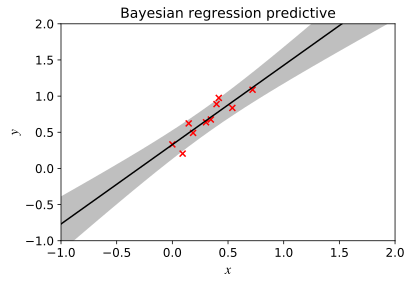

In [3]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays

var_w = 1
var_y = 0.03

phi = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_lin]) # X instantiated more elegantly here

pre_w = 1/var_w * np.eye(2) # prior covariance matrix to include in MAP solution

S = np.linalg.inv((phi.T).dot(phi) / var_y + pre_w) # posterior distribution covariance matrix
mu = S.dot(phi.T).dot(y_lin)/var_y # MAP weights to use in mean(y*)


x_pred = np.linspace(-5, 5, 100)
X_pred = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_pred])

mu_pred = X_pred.dot(mu) # calculate mean(y*)
stdev_pred = (np.sum(X_pred.dot(S) * X_pred, axis = 1) + var_y) ** 0.5 # calculate Var(y*)^0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred, facecolor = 'grey', alpha = 0.5) # plot confidence intervals = +/- Var(y*)^0.5
plt.scatter(x_lin, y_lin, marker = 'x', color = 'red') # plot data
plt.plot(x_pred, mu_pred, color = 'black') # plot mean(y*)
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.show()

toggle_code()

The solid black line shows the mean of the predictive distribution $
\mu_{y^*|\mathbf{y},\mathbf{X}}$, and the grey area shows one standard deviation around this $\pm 
\sigma_{y^*| \mathbf{y},\mathbf{X}}$. Notice how the uncertainty grows away from the region where we have seen data. This seems reasonable, as uncertainty in the gradient of a straight line fit would have a larger effect as we move away from the data region.  

Let's apply this method to the non-linear dataset.

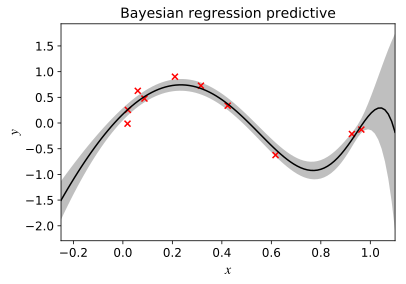

In [4]:
# exactly the same process with the linear case, except phi is different

x_nonlin = np.load('reg_nonlin_x.npy') 
y_nonlin = np.load('reg_nonlin_y.npy') # loading the non-linear dataset

var_w = 10
var_y = 0.01
D = 11;

phi = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_nonlin])
pre_w = 1/var_w * np.eye(D+1) # prior covariance matrix to include in MAP solution

S = np.linalg.inv((phi.T).dot(phi) / var_y + pre_w) # posterior distribution covariance matrix
mu = S.dot(phi.T).dot(y_nonlin)/var_y # MAP weights to use in mean(y*)

x_pred = np.linspace(-0.25, 1.1, 100)
phi_pred = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_pred])

mu_pred = phi_pred.dot(mu)
stdev_pred = (np.sum(phi_pred.dot(S) * phi_pred, axis = 1) + var_y) ** 0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred,
                 facecolor = 'grey', alpha = 0.5)
plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red')
plt.plot(x_pred, mu_pred, color = 'black')
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-0.25, 1.1])
plt.show()

toggle_code()

In the next [notebook](regression_bayesian-online-visualisations.ipynb) we will look at how to visualise and better understand the posterior distribution over the weights using a process called *online learning*.

## Summary

Having covered bayesian linear regression, you should now understand:

1. Why finding the $\mathbf{w}$ using MAP with a gaussian likelihood and prior is equivalent to doing least-squares with $\mathbf{L2}$ regularization
2. How to take a bayesian inference approach to regression problems, including how to calculate $\mathbb{E}$(y) and Var(y) for your fitted model.


## Questions 

1a. Consider the the Bayesian regression described above. Show that, in addition to the number of datapoints $N$, the posterior distribution only requires the following statistics to be computed from the training data,

\begin{align}
\mu^{(N)}_{d} &= \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) y_n, \;\; \text{and} \;\;
\Sigma^{(N)}_{d,d'} = \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) \phi_{d'}(\mathbf{x}_n). 
\end{align}


<details>
<summary>Answer</summary>
<div>
Computing the posterior distribution requires the following two statistics $\boldsymbol{\Phi}^\top \mathbf{y}$   and $\boldsymbol{\Phi}^\top \boldsymbol{\Phi}$. Dividing these two statistics by $N$ and expanding them using index notation yields the expressions above.
    
The fact that the inference depends only on the empirical average of a small number of simple functions of the data is an example of **suffiecnt statistics**. Sufficient statistics arise when employing probabilistic models with elements that employ [exponential family distributions](https://en.wikipedia.org/wiki/Exponential_family) like the Gaussian.
</div>
</details>

1b. Consider applying Bayesian regression on streaming data where one datapoint $\{ \mathbf{x}_n, y_n\}$ arrives at a time and the posterior is continually updated as data come in. 

Derive an update where the statistics ($\mu^{(N)}_{d}$ and $\Sigma^{(N)}_d$) are recomputed using the old values of the statitics ($\mu^{(N-1)}_{d}$ and $\Sigma^{(N-1)}_d$) and the current datapoint ($\{ \mathbf{x}_n, y_n\}$). 

What advantage does this have for very long data streams $N \rightarrow \infty$?


<details>
<summary>Answer</summary> 
    
<div>
    Consider the update for $\mu^{(N)}_{d}$. Splitting out the contribution from the $N$th datapoint, we have  

\begin{align}
\mu^{(N)}_{d} &= \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) y_n = \frac{1}{N} \left(\phi_d(\mathbf{x}_N) y_N + \sum_{n=1}^{N-1} \phi_d(\mathbf{x}_n) y_n \right )\\ 
    &  = \frac{1}{N} \left(\phi_d(\mathbf{x}_N) y_N + \frac{N-1}{N-1}\sum_{n=1}^{N-1} \phi_d(\mathbf{x}_n) y_n \right)\\
    &  = \frac{1}{N} \phi_d(\mathbf{x}_N) y_N + \frac{N-1}{N} \mu^{(N-1)}_d
\end{align}

This is the idea of a 'running average'. Similarly for $\Sigma^{(N)}_{d,d'}$ 

\begin{align}
\Sigma^{(N)}_{d,d'} &= \frac{1}{N} \phi_d(\mathbf{x}_N) \phi_{d'}(\mathbf{x}_N) + \frac{N-1}{N} \Sigma^{(N-1)}_{d,d'}. 
\end{align}

These updates do not require the entire dataset to be retained. They just require the old statistics and the current datapoint, which can be much more efficient in terms of memory. This idea relates to [online inference](regression_bayesian-online-visualisations.ipynb).

</div>
</details>